In [11]:
#Import Libraries
import numpy as np
import numba as nb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import scipy as sc
from scipy.integrate import odeint

import matplotlib as mpl

In [2]:
#settings for plots

#tableau for plots
plt.style.use('tableau-colorblind10')

plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 16        # Default font size for text
plt.rcParams['axes.titlesize'] = 16   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 16   # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 16  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size for y tick labels

In [84]:
#Definitions used in self-consistent equations of stat DMFT
def P_z(z):
    return 1/np.sqrt(2*np.pi)*np.exp(-z**2/2)

def J(x, K):
    return x/(1+K*x)  

def dJdx(x, K):
    return 1/(1+K*x)**2

def f_prim(z, Q, q, chi, mu, sigma, gamma, K):
    eta = np.sqrt(q)*sigma*z
    t = 1+mu*Q+eta
    y = 1-gamma*sigma**2*chi
    return 2*t*(K-(4*K-2*K*(y-K*t))/(2*np.sqrt((y-K*t)**2+4*K*t)))/(K*t-y-np.sqrt((y-K*t)**2+4*K*t))**2-2/(K*t-y-np.sqrt((y-K*t)**2+4*K*t))

def x_z(z, Q, q, chi, mu, sigma, gamma, K):
    eta = np.sqrt(q)*sigma*z
    t = 1+mu*Q+eta
    y = 1-gamma*sigma**2*chi
    return -2*t/(K*t-y-np.sqrt((K*t-y)**2+4*K*t))

def Delta(Q, q, sigma):
    return (1+mu*Q)/(np.sqrt(q)*sigma)

def integrand0(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*J(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)
    
def integrand1(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*J(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)**2

def integrand2(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)* f_prim(z, Q, q, chi, mu, sigma, gamma, K)

In [85]:
#Self consistent equations
def equations(y, mu, sigma, gamma, K):
    
    Q = y[0]
    q = y[1]
    chi = y[2]

    eq0 = Q - sc.integrate.quad(integrand0, -Delta(Q, q, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq1 = q - sc.integrate.quad(integrand1, -Delta(Q, q, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq2 = chi - sc.integrate.quad(integrand2, -Delta(Q, q, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    
    return [eq0, eq1, eq2]

In [86]:
def f_inv_SAD(x, sigma, gamma, K, chi):
    return x-gamma*sigma**2*chi*J(x, K)

def f_prim_SAD(t, y, K):
    sq = np.sqrt(4*K*t+(K*t-y)**2)
    temp = 2*t*(K-(4*K-2*K*(-K*t+y))/(2*sq))/(K*t-y-sq)**2-2/(K*t-y-sq)
    return temp

def prob_extinction(mu, sigma, gamma, avg_J, avg_J2):
    m = 1+mu*avg_J
    nu = sigma*np.sqrt(avg_J2)
    return  1/2*sc.special.erfc(m/(np.sqrt(2)*nu))

#Theoretical SAD
def SAD(x_list, mu, sigma, gamma, K, Q, q, chi, thresh = 0.001):
    
    m = 1 + mu*Q
    nu = sigma*np.sqrt(q)
    y = 1-gamma*sigma**2*chi
    
    p = []
    for x in x_list:
        
        f_i = f_inv_SAD(x, sigma, gamma, K, chi)
        f_p = f_prim_SAD(f_i, y, K)
        out = 0

        if(x<thresh):
            #Extinction probability
            out = out + prob_extinction(mu, sigma,gamma, Q, q)
            
        #Gaussian (if gamma=0) contribute
        out = out + 1/(np.sqrt(2*np.pi)*nu)*np.exp(-(f_i-m)**2/(2*nu**2))/(f_p)
                       
        p.append(out)
        
    return np.array(p)

In [87]:
#Example of SAD

#Parameters
mu = 0
sigma = 1
gamma = -1
K = 1

#Self-consistency solutions
initial_guess = [0.33025696, 0.32220374, 0.48581894]
# Solve the system numerically
solution = fsolve(equations, initial_guess, args = (mu, sigma, gamma, K))

Q = solution[0]
q = solution[1]
chi = solution[2]

#SAD
x_list = np.linspace(0, 10, 1000)
theo = SAD(x_list, mu, sigma, gamma, K, Q, q, chi )

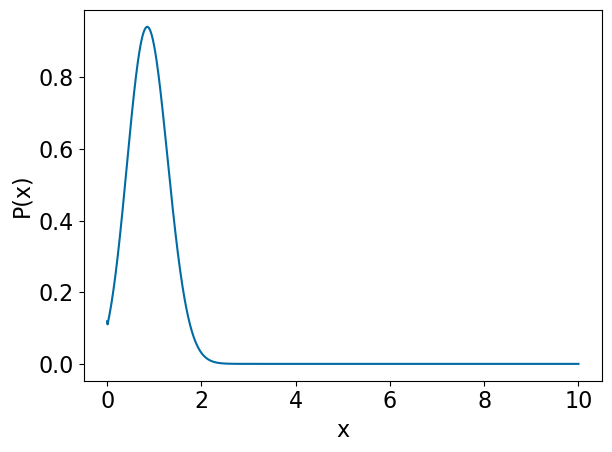

In [88]:
#plot
plt.plot(x_list, theo)
plt.xlabel('x')
plt.ylabel('P(x)')
plt.show()

### GLV model integration

In [19]:
#Parameters of integration 
t_max = 50  #maximum time
dt = 0.1    #time step
N_steps = int(t_max/dt)  
t = np.linspace(0, t_max, N_steps) #time

In [14]:
def GLV(y, t, alpha, K):
    '''
        Definition of the function to pass as parameter to odeint() of scipy.integrate for itegrating ODE
    '''
    dydt = np.zeros_like(y)
    for i in range(N):
        dydt[i] = y[i]*(1-y[i]+np.dot(alpha[i, :], J(y, K)))
        
    return dydt

In [15]:
def ODE_integration_GLV(N, mu, sigma, gamma, K, initial_condition = 'uniform'):
    
    #covariance matrix and mean for sampling
    cov = [[1, gamma], [gamma, 1]]
    mean = [0,0]
    
    alpha = np.zeros([N, N]) #matrix of interactions
    
    #sampling of interactions
    for i in range(N):
        for j in range(i, N):
            z = np.random.multivariate_normal(mean, cov)
            alpha[i, j] = mu/N+sigma/np.sqrt(N)*z[0]
            alpha[j, i] = mu/N+sigma/np.sqrt(N)*z[1]

    #Sampling random initial conditions
    if type(initial_condition)!= str:
            y0 = initial_condition

    elif initial_condition == 'uniform':
        y0 = np.random.uniform(0, 1, N)
    

    sim_GLV = odeint(GLV, y0, t, args=(alpha, K)) #integration
            
            
    phi = np.sum(sim_GLV[-1, :]>0)/N #fraction of survived species
    extincted = 1 - phi #fraction of extincted species
    
    return sim_GLV  #useful only for M=1 and B=1

### Theoretical SAD and integrated GLV comparison

In [68]:
#Parameters
mu = 0
sigma = 1
gamma = -1
K = 1

In [89]:
#THEORETICAL SOLUTION

#Self-consistency solutions
initial_guess = [0.39843345, 0.17356345, 0.6873497 ]
# Solve the system numerically
solution = fsolve(equations, initial_guess, args = (mu, sigma, gamma, K))

Q = solution[0]
q = solution[1]
chi = solution[2]

#SAD
x_list = np.linspace(0, 10, 1000)
theo = SAD(x_list, mu, sigma, gamma, K, Q, q, chi  )

In [79]:
(mu, sigma, gamma, K)

(0, 1, -1, 1)

In [66]:
#SIMULATIONS
N = 200
n_sim = 25

stat_samples = np.array([])

for _ in range(n_sim):
    sim_GLV = ODE_integration_GLV(N, mu, sigma, gamma, K, initial_condition = 'uniform')
    stat_samples = np.concatenate((stat_samples, sim_GLV[-1, :]))

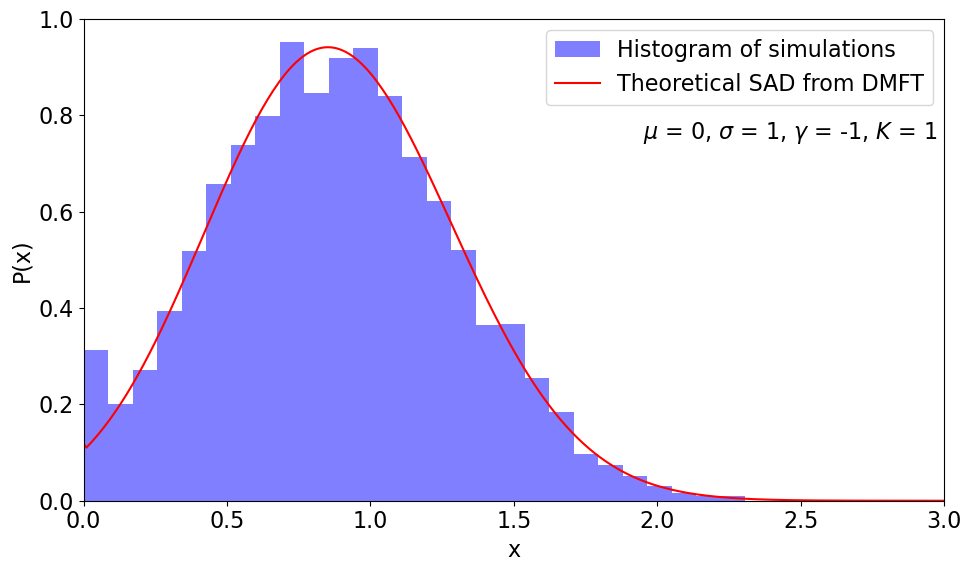

In [90]:
plt.figure(figsize=(10, 6))

plt.hist(stat_samples, density = True, color = 'blue', bins = 30, alpha = 0.5, label = 'Histogram of simulations')
plt.plot(x_list, theo, color = 'red', label = 'Theoretical SAD from DMFT')

plt.xlim((0, 3))
plt.ylim((0, 1))

plt.text(0.65, 0.75, r'$\mu$ = {}, $\sigma$ = {}, $\gamma$ = {}, $K$ = {}'.format(mu, sigma, gamma, K), fontsize = 16, transform=plt.gca().transAxes)

plt.xlabel('x')
plt.ylabel('P(x)')
plt.legend()

plt.savefig('results/SAD_mu{}_sigma{}_gamma{}_K{}.png'.format(mu, sigma, gamma, K), pad_inches = 0.1, bbox_inches = 'tight')